## 4.	Traitement des données prétraitées

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import gmean


# Liste des mois à traiter
list_mois = [
    "Mai", 
    "Juin", 
    "Juillet", 
    "Aout"
             ]

# Identifier les colonnes numériques sur lesquelles appliquer l'imputation et le traitement des valeurs aberrantes
numerical_columns = ['loyer_mensuel']

# Fonction de traitement des valeurs aberrantes avec IQR
def treat_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# Fonction pour calculer les bornes
def calculate_price_ranges(price):
    lower_bound = price * (1-0.15)
    upper_bound = price * (1+0.15)
    return lower_bound, upper_bound


# Fonction pour imputer les valeurs manquantes
def impute_missing_prices(df, df_previous_month, current_month_column, mois):
    # Conversion des types de 'code_var 2014' en chaîne pour correspondance
    df['code_var 2014'] = df['code_var 2014'].astype(int)
    df_previous_month['code_var 2014'] = df_previous_month['code_var 2014'].astype(int)
    
    # Identifier la colonne de référence pour les prix du mois précédent
    if mois == "Mai" or mois == "Juin":
        previous_column = "Mai"
    else:
        previous_column = "loyer_mensuel"  # Colonne du fichier de référence pour Juillet et Août
    
    # Calculer la moyenne géométrique pour chaque code_var 2014
    previous_geom_means = df_previous_month.groupby('code_var 2014')[previous_column].apply(lambda x: gmean(x[x > 0])).reset_index()
    current_geom_means = df.groupby('code_var 2014')['loyer_mensuel'].apply(lambda x: gmean(x.dropna())).reset_index()

    previous_geom_means.columns = ['code_var 2014', 'previous_geom_mean']
    current_geom_means.columns = ['code_var 2014', 'current_geom_mean']
    
    # Fusionner les deux DataFrames pour obtenir les moyennes géométriques précédentes et actuelles
    merged_geom_means = pd.merge(current_geom_means, previous_geom_means, on='code_var 2014', how='left')
    
    for index, row in df.iterrows():
        if pd.isna(row['loyer_mensuel']):
            code_var = row['code_var 2014']
            # Récupérer la moyenne géométrique du mois précédent
            previous_mean_row = merged_geom_means[merged_geom_means['code_var 2014'] == code_var]
            if not previous_mean_row.empty:
                previous_geom_mean = previous_mean_row['previous_geom_mean'].values[0]
                
                if not pd.isna(previous_geom_mean):
                    # Imputer le loyer en fonction de la variation de la moyenne géométrique
                    current_geom_mean = previous_mean_row['current_geom_mean'].values[0]
                    if not pd.isna(current_geom_mean):
                        variation_moyenne = current_geom_mean / previous_geom_mean
                    else:
                        variation_moyenne = 1  # Si la moyenne géométrique actuelle est manquante, ne pas appliquer de variation
                        
                    df.at[index, 'loyer_mensuel'] = previous_geom_mean * variation_moyenne
                    print(f"Imputation faite pour {code_var} avec le nouveau prix {df.at[index, 'loyer_mensuel']}.")
                else:
                    print(f"Impossible de calculer le prix pour {code_var}, la moyenne géométrique précédente est manquante.")
            else:
                print(f"Code_var {code_var} non trouvé dans les données du mois précédent.")
    
    return df


# Fonction pour traiter les données de loyer pour chaque mois
def process_rent_data(df, mois, previous_month, current_month_column, df_previous_month):
    # Conversion des types de 'code_var 2014' en chaîne pour correspondance
    df['code_var 2014'] = df['code_var 2014'].astype(int)
    df_previous_month['code_var 2014'] = df_previous_month['code_var 2014'].astype(int)
    
    # Calcul de la moyenne géométrique des loyers pour chaque code_var 2014
    if mois == "Mai" or mois == "Juin":
        geom_mean_prices = df_previous_month.groupby('code_var 2014')['Mai'].apply(lambda x: gmean(x[x > 0])).reset_index()
    else:
        geom_mean_prices = df_previous_month.groupby('code_var 2014')['loyer_mensuel'].apply(lambda x: gmean(x[x > 0])).reset_index()

    geom_mean_prices.columns = ['code_var 2014', 'geom_mean']

    # Calcul des bornes pour chaque code_var 2014 à partir de la moyenne géométrique
    geom_mean_prices['min'], geom_mean_prices['max'] = zip(*geom_mean_prices['geom_mean'].map(calculate_price_ranges))

    # Transformer en dictionnaire pour accès rapide
    price_ranges = geom_mean_prices.set_index('code_var 2014')[['min', 'max']].T.to_dict('list')

    # Ramener les loyers qui sont hors de bornes à None
    for index, row in df.iterrows():
        code_var = row['code_var 2014']
        loyer = row['loyer_mensuel']
        
        if code_var in price_ranges:
            min_price, max_price = price_ranges[code_var]
            if not min_price <= loyer <= max_price:
                df.at[index, 'loyer_mensuel'] = None
    df = impute_missing_prices(df, df_previous_month, current_month_column, mois)
    return df

# Boucle à travers les mois pour traiter chaque mois séquentiellement
for i, mois in enumerate(list_mois):
    if mois == "Mai":
        previous_month_file = 'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Cacul_de_l_indice\\Prix_mois_precedent.xlsx'
        current_month_column = "Mai"
    elif mois == "Juin":
        previous_month_file = 'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Cacul_de_l_indice\\Prix_mois_precedent.xlsx'
        current_month_column = "Mai"  # Utiliser Mai comme référence pour Juin aussi
    else:
        previous_month = list_mois[i-1]
        previous_month_file = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\datasets_traites\\{previous_month}_traitee.xlsx'
        current_month_column = "loyer_mensuel"


    # Charger les données du mois précédent
    df_previous_month = pd.read_excel(previous_month_file)

    # Charger les données du mois en cours
    df = pd.read_excel(f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\Datasets_pretraites\\pretraitees\\{mois}_pretraitee.xlsx')

    # Étape 4.1 : Analyse et traitement des valeurs manquantes
    print("Étape 4.1 : Analyse et traitement des valeurs manquantes")
    
    def remove_rows_with_empty_region(df):
        df_cleaned = df.dropna(subset=['region'])
        return df_cleaned

    df = remove_rows_with_empty_region(df)
    
    df['commune'].fillna('inconnue', inplace=True)
    df['quartier'].fillna('inconnue', inplace=True)

    # Classification des logements
    print("2.10. Classification des logements selon les variétés")
    
    # Code pour la classification des logements ici...
    code_mapping = {
    
    #'type', 'pieces', 'eau', 'elec', 'en_dur', 'wc', 'cours_com', 'quartier'
    
        # Loyer d'un appartement moderne, Avec/sans eau: avec, Avec/sans electricité: avec
        (r'appartement', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000002",

        (r'appartement', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000002",
        #
        (r'appartement', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000002",
        (r'appartement', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000002",

        # Loyer brut mensuel d'une maison de 2 à  3 pieces dans une cour commune avec toile
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'1', r'1'): "401000003",
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'1', r'0'): "401000003",
    (r'appartement', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'1', r'0'): "401000003",
    (r'appartement', r'2 et 3 pièces', r'1', r'1', r'1', r'1', r'1', r'1'): "401000003",

        
        # Loyer brut mensuel d'un logement de 2 à  3 pieces dans une cour commune sans toil
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'0', r'1', r'1'): "401000004",
    (r'appartement', r'2 et 3 pieces', r'1', r'1', r'1', r'0', r'1', r'1'): "401000004",
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'0', r'1', r'0'): "401000004",
    (r'appartement', r'2 et 3 pieces', r'1', r'1', r'1', r'0', r'1', r'0'): "401000004",
        
        # Loyer d'une maison, Cour commune: Non, Matériaux: en dur, toilettes internes: oui
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000005",
        (r'maison', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000005",
  
    
        # Loyer d'une maison duplex , Matériaux: en dur, toilettes internes: oui 1 ou plusieurs, type de quartier : chic.
        (r'duplex', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000006",
        (r'duplex', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000006", 
        (r'duplex', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000006",
        (r'duplex', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000006", 
        (r'maison', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'0'):"401000006",
        (r'maison', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'1'):"401000006",  
        
        
        # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Non,  Toilettes internes: Oui. Autres caractéristiques: à plusieurs appartements,
        (r'studio', r'1 piece', r'1', r'1', r'1', r'1', r'0', r'1'): "401000007",
        (r'studio', r'1 piece', r'1', r'1', r'1', r'1', r'0', r'0'): "401000007",
        
        # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Non,  Toilettes internes: Oui. Autres caractéristiques: à plusieurs appartements,
        (r'studio', r'1 piece', r'1', r'1', r'1', r'1', r'0', r'1'): "401000008",
        (r'studio', r'1 piece', r'1', r'1', r'1', r'1', r'0', r'0'): "401000008",

        # Loyer d'un logement, Type: studio, Nombre de chambre à coucher:  1, Matériaux;  dur, Cour commune: Oui,  Toilettes internes: non, Autres caractéristiques: maison basse, à plusieurs appartements, type de quartier: populaire
        (r'studio', r'1 piece', r'1', r'1', r'1', r'0', r'1', r'0'): "401000009",     
        
        #Loyer Villa moderne, clôture: Oui, cours: avec, sanitaires internes: Oui, habitée par un seul locataire: Oui, Type de quartier: résidentiel
        (r'villa', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010", 
        (r'villa', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'1'): "401000010", 
        
        #Loyer Villa moderne, clôture: Oui, cours: avec, sanitaires internes: Oui, habitée par un seul locataire: Oui, Type de quartier: populaire
        (r'villa', r'2 et 3 pieces', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",
        (r'villa', r'4 pieces et plus', r'1', r'1', r'1', r'1', r'0', r'0'): "401000011",     

    }

    def get_classification_code(row, code_mapping):
        key = (
            row['type_immobilier'],
            row['nb_pieces_classe'],
            str(row['Avec_eau']),
            str(row['Avec_electricite']),
            str(row['Materiaux_en_dur']),
            str(row['Toilettes_internes']),
            str(row['cours_commune']),
            str(row['quartier_chic'])
        )
        code = code_mapping.get(key, None)
        if code is None:
            print(f"Key not found: {key}")
        return code

    df['code_var 2014'] = df.apply(get_classification_code, axis=1, code_mapping=code_mapping)
    df = df.dropna(subset=['code_var 2014'])

    # Gestion des incohérences
    def remove_incoherent_rows(df):
        incoherence_condition = (
            ((df['loyer_mensuel'] < 50000) & (df['nb_pieces'] > 3)) |
            ((df['loyer_mensuel'] > 300000) & (df['nb_pieces'] < 3)) |
            ((df['nb_pieces'] <= 0) | (df['nb_pieces'].isnull()))
        )
        df_cleaned = df[~incoherence_condition]
        return df_cleaned

    df = remove_incoherent_rows(df)

    # Traitement des valeurs atypiques
    df = process_rent_data(df, mois, previous_month, current_month_column, df_previous_month)

    # Par variété (code_var 2014)
    for column in numerical_columns:
        for variete in df['code_var 2014'].unique():
            df_variete = df[df['code_var 2014'] == variete].copy()
            df_variete = treat_outliers(df_variete, column)
            df.update(df_variete)
            
            
    # Liste des colonnes dans l'ordre souhaité
    colonnes_ordre = [
        'code_var 2014', 'grappe', 'region', 'ville', 'commune', 'quartier', 'title', 'loyer_mensuel', 
        'localisation', 'nb_pieces', 'nb_salle_de_bain', 'type_immobilier', 'site', 
        'superficie_m2', 'annonceur', 'Avec_eau', 'Avec_electricite', 'Materiaux_en_dur', 
        'Toilettes_internes', 'cours_commune', 'quartier_chic', 'nb_pieces_classe', 'wifi', 'jardin', 
        'meubler', 'climatisation', 'garage', 'balcon', 'sécuriser', 'étage', 'parking', 'douche', 
        'séjour', 'équiper', 'placard', 'salle', 'manger', 'bureau', 'piscine', 'gardien', 'électrogène', 
        'four', 'cinéma', 'ascenseur', 'double vitrage', 'terrasse', 'toilette', 'buanderie', 'chauffe', 
        'cuisine', 'bord_de_mer', 'forêt', 'parc', 'montagne', 'rivière', 'lac', 'zone_commerciale', 
        'pharmacie', 'restaurant', 'bar', 'ambassade', 'école', 'hôpital', 'commodités', 
        'externalités_naturelles', 'externalités_artificielles', 'link', 'description'
    ]

    # Réorganiser les colonnes du DataFrame
    df = df[colonnes_ordre]
    
    
    # Étape 4.4 : Stockage des données traitées
    import platform
    if platform.system() == 'Windows':
        output_path_final = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\datasets_traites\\{mois}_traitee.xlsx'
    else:
        output_path_final = f'/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Traitements/datasets_traites/{mois}_traitee.xlsx'

    
    df.to_excel(output_path_final, index=False)
    print(f"Données traitées pour le mois de {mois} enregistrées avec succès dans {output_path_final}.")


Étape 4.1 : Analyse et traitement des valeurs manquantes
2.10. Classification des logements selon les variétés
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000008 avec le nouveau prix 81585.43803138913.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation faite pour 401000002 avec le nouveau prix 120078.36189120561.
Imputation fai

C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Données traitées pour le mois de Mai enregistrées avec succès dans D:\Bureau\MemoiresStages\Travaux_techniques\Traitements\datasets_traites\Mai_traitee.xlsx.
Étape 4.1 : Analyse et traitement des valeurs manquantes
2.10. Classification des logements selon les variétés
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000005 avec le nouveau prix 100000.00000000001.
Imputation faite pour 401000008 avec le nouveau prix 82505.91904937934.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Im

C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000008 avec le nouveau prix 82505.91904937934.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix 120948.13405321047.
Imputation faite pour 401000002 avec le nouveau prix

C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Wilfried KOMENAN\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000008 avec le nouveau prix 83233.91785958463.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix 125467.13471045953.
Imputation faite pour 401000002 avec le nouveau prix

## Visualisation

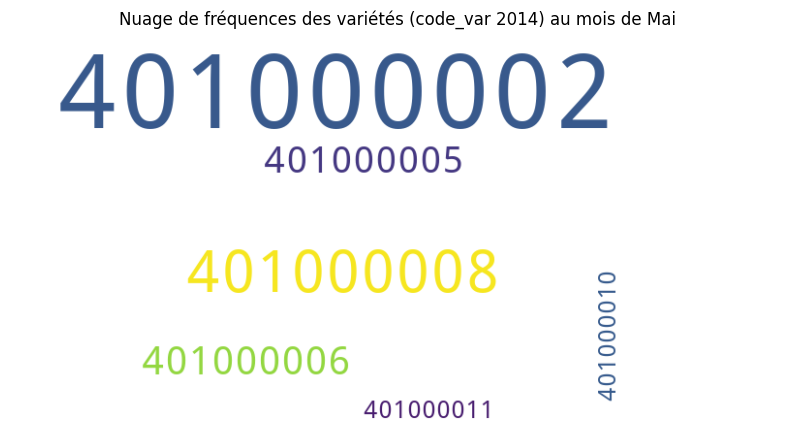

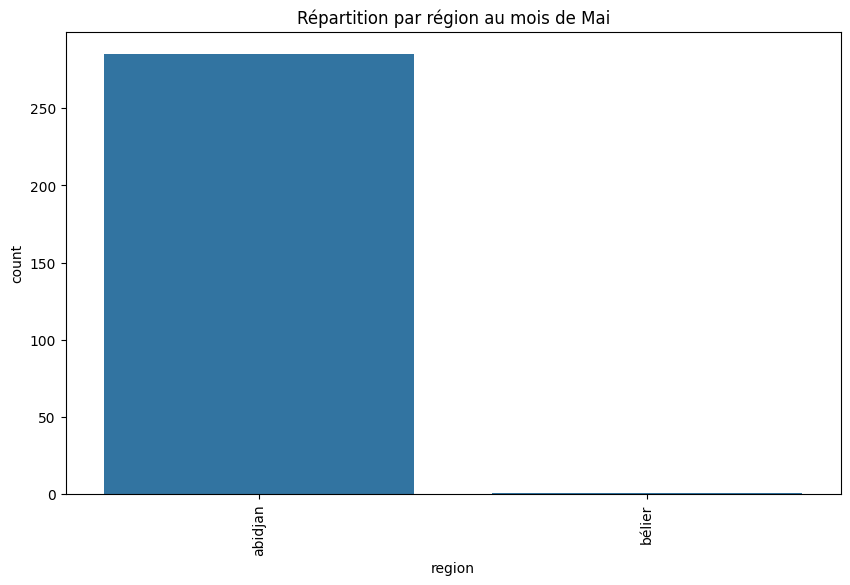

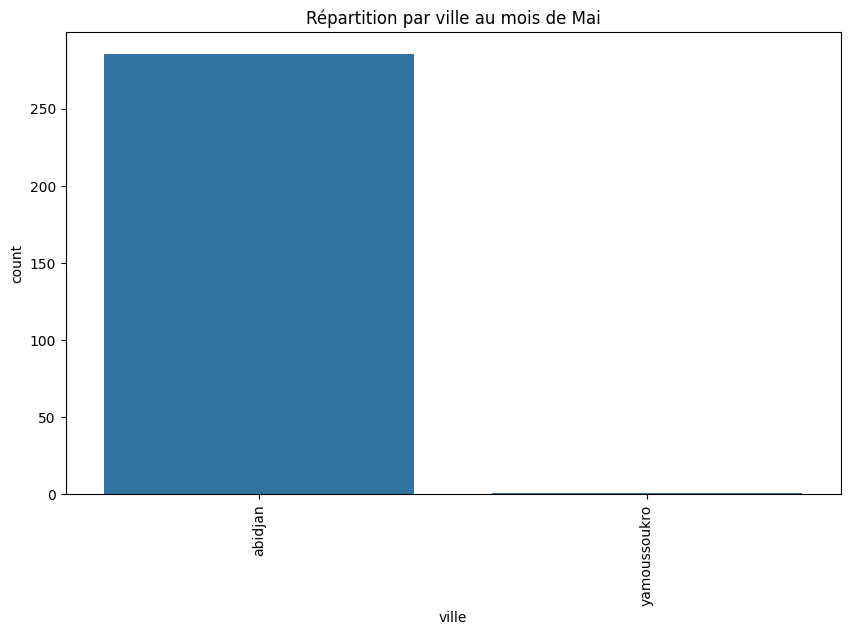

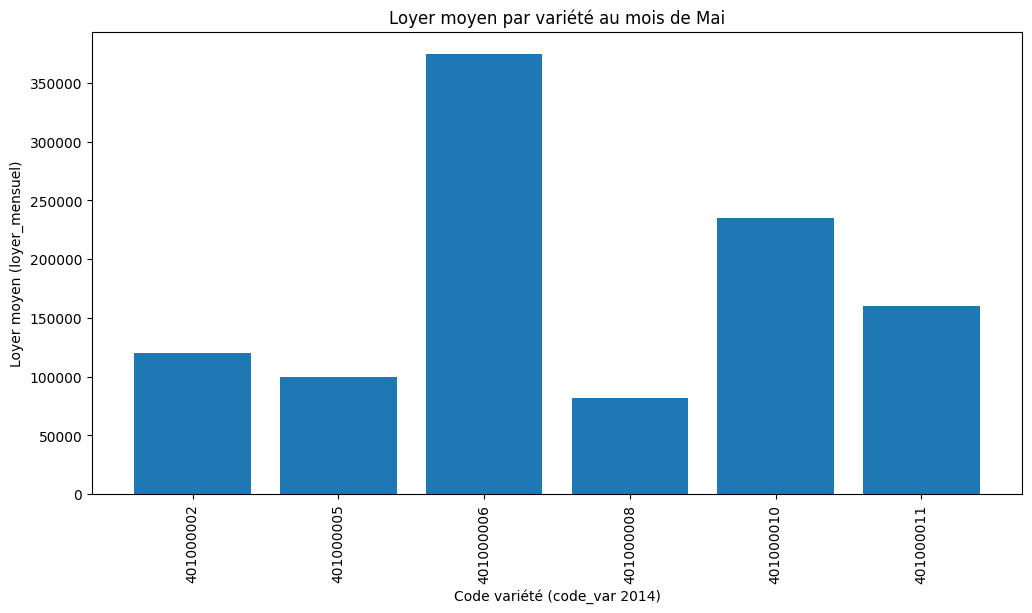

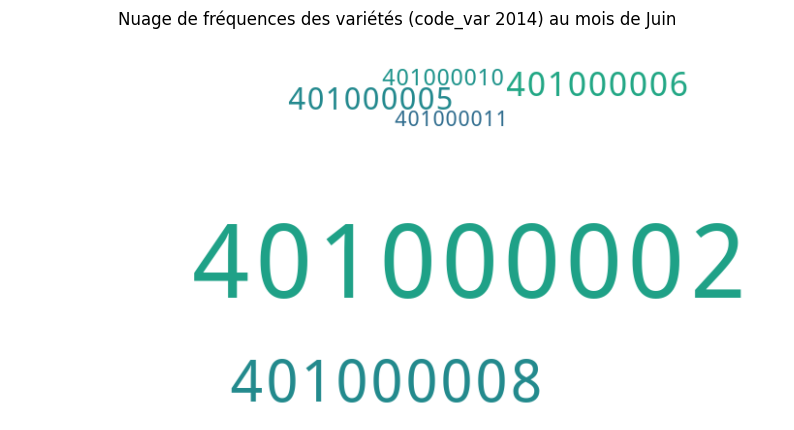

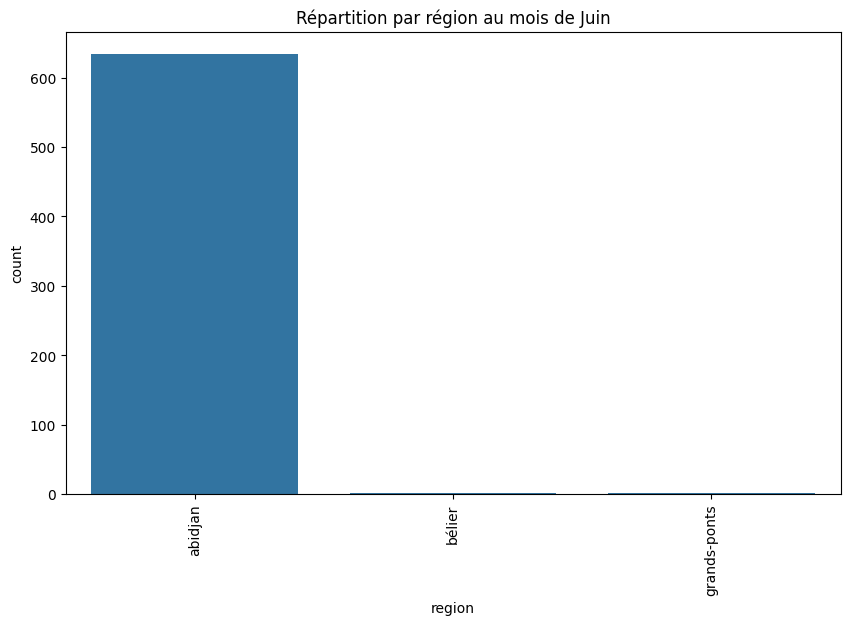

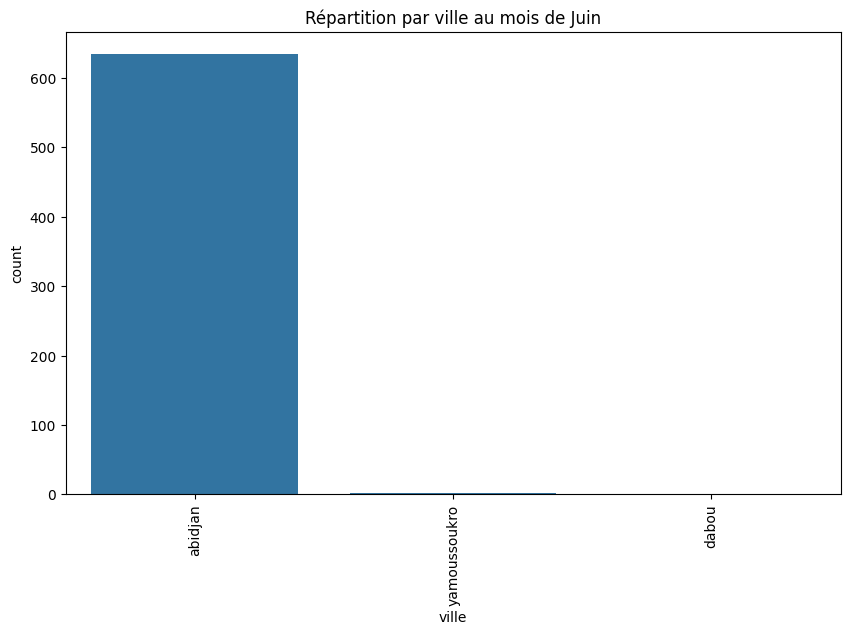

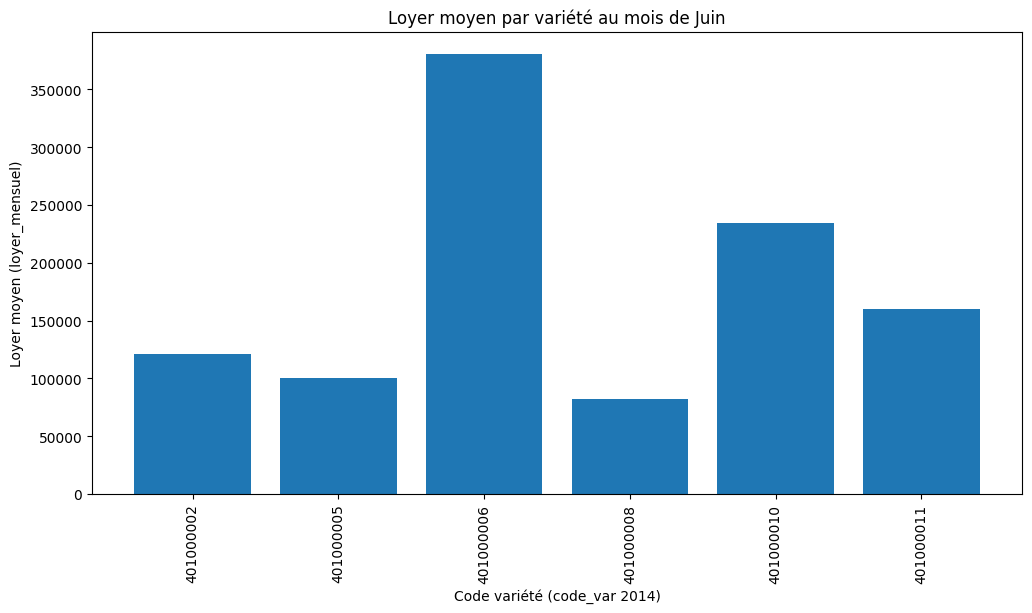

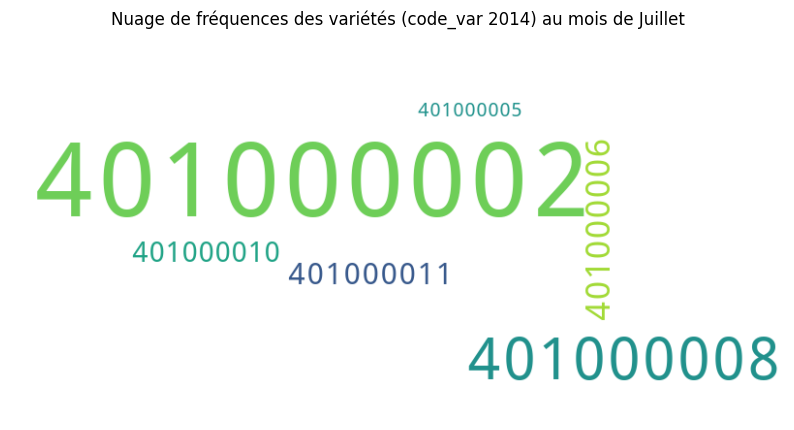

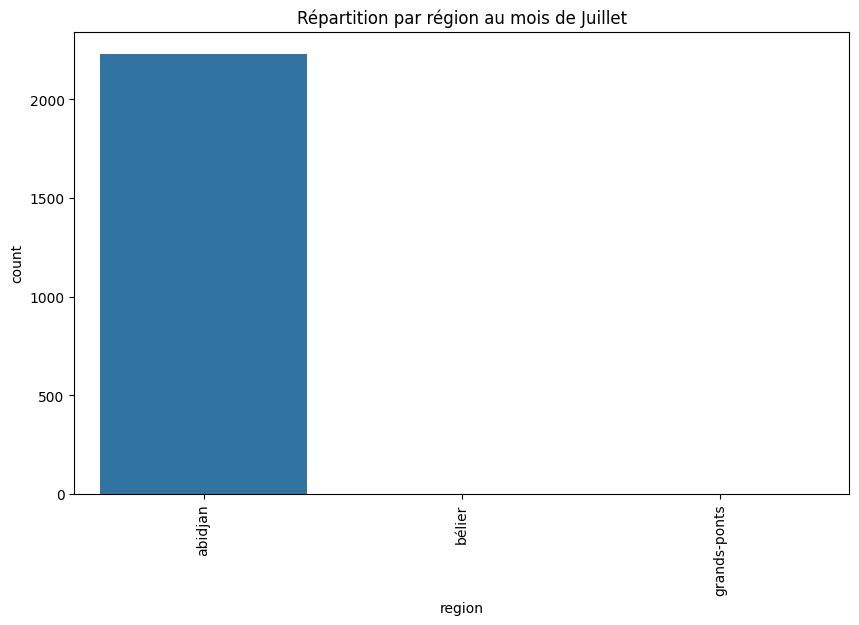

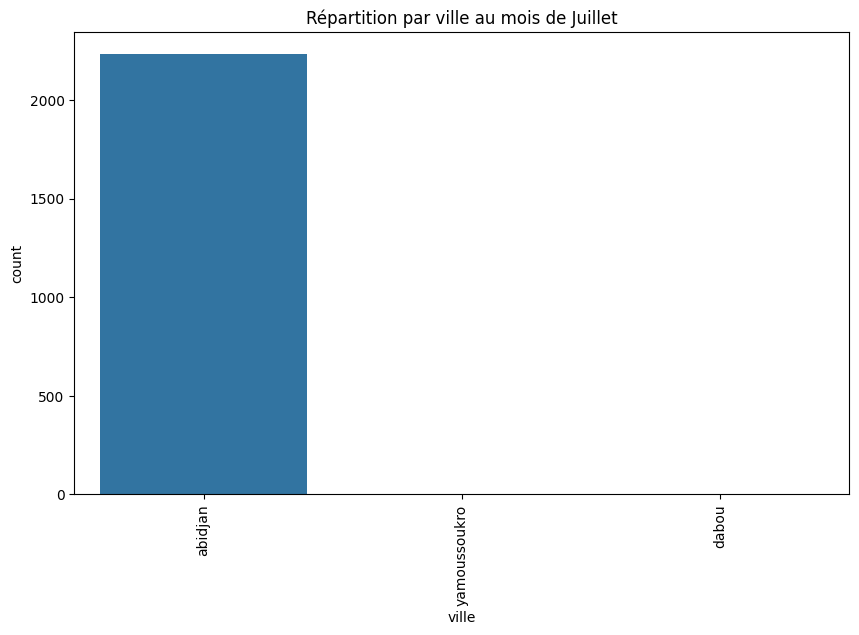

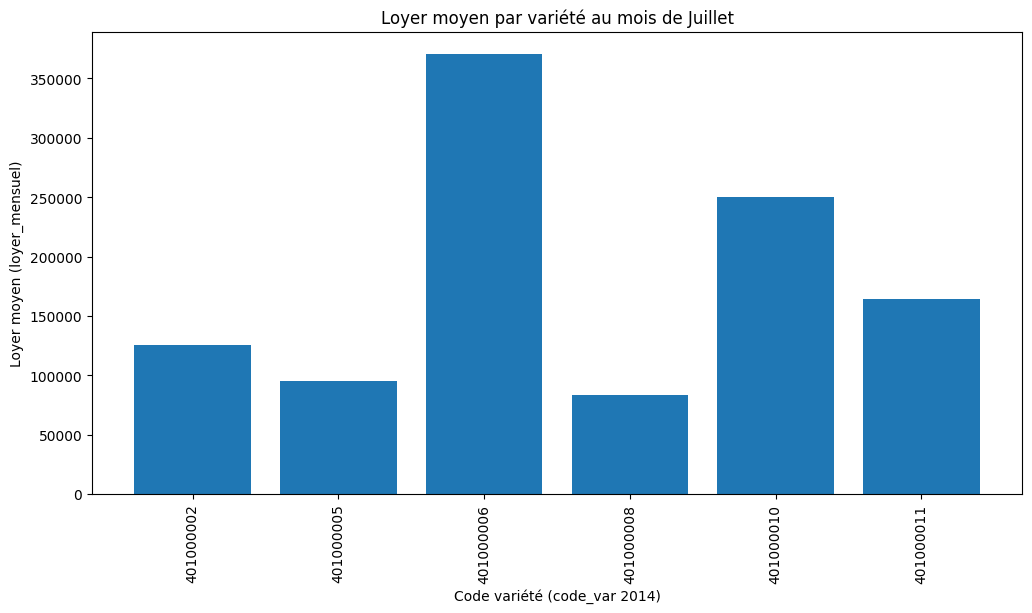

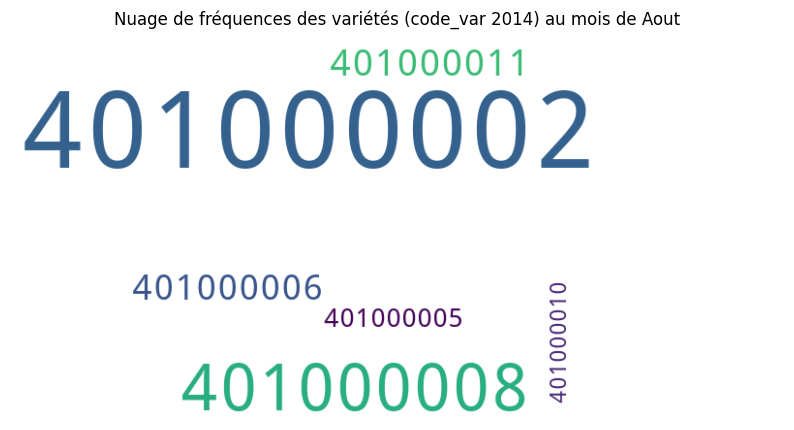

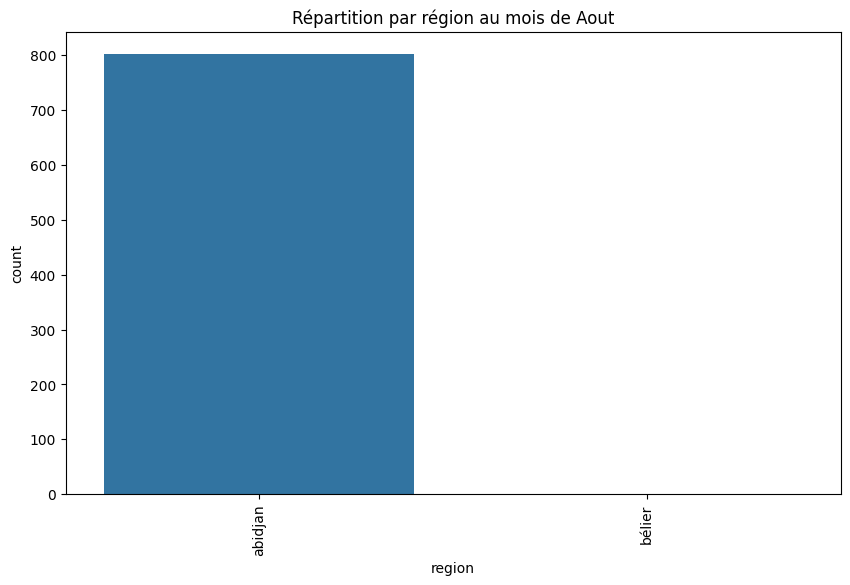

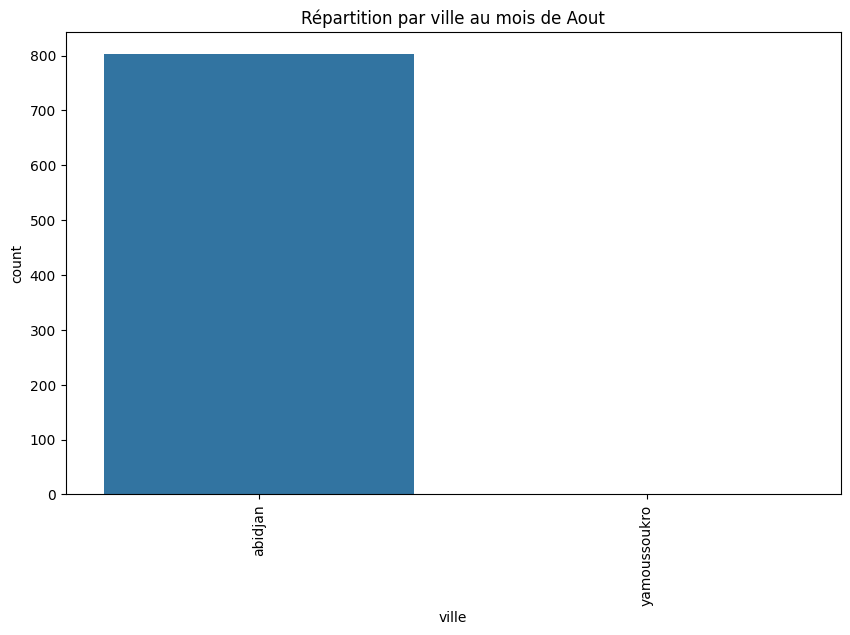

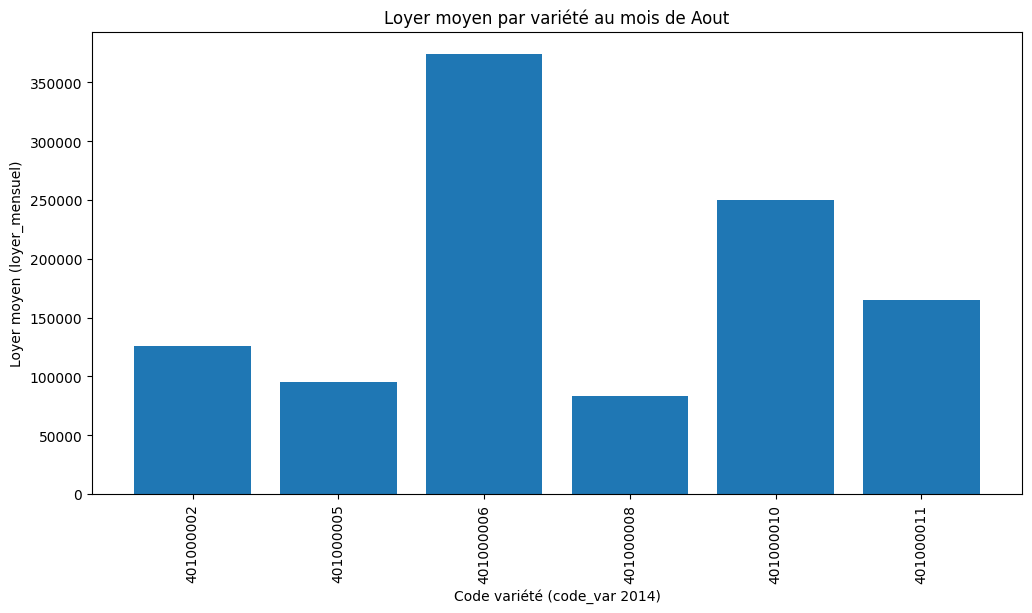

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

list_mois = [
    "Mai", 
    "Juin", 
    "Juillet",
    "Aout"
    ]

for mois in list_mois:
    # Charger les données traitées
    import platform
    if platform.system() == 'Windows':
        output_path_final = f'D:\\Bureau\\MemoiresStages\\Travaux_techniques\\Traitements\\datasets_traites\\{mois}_traitee.xlsx'
    else:
        output_path_final = f'/mnt/d/Bureau/MemoiresStages/Travaux_techniques/Traitements/datasets_traites/{mois}_traitee.xlsx'

    df = pd.read_excel(output_path_final)

    
    # Étape 5.1 : Nuage de fréquences basé sur la colonne 'code_var 2014'
    
    # Filtrer les valeurs manquantes dans la colonne 'code_var 2014'
    df = df[df['code_var 2014'].notna()]

    if not df.empty:
        # Créer un dictionnaire des fréquences des valeurs de 'code_var 2014' en tant que chaînes
        frequencies = df['code_var 2014'].astype(str).value_counts().to_dict()

        if frequencies:  # Vérifier que le dictionnaire n'est pas vide
            try:
                # Générer le nuage de fréquences
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

                # Afficher le nuage de fréquences
                plt.figure(figsize=(10, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")  # Désactiver les axes
                plt.title(f"Nuage de fréquences des variétés (code_var 2014) au mois de {mois}")
                plt.show()
            except ValueError as e:
                print(f"Erreur lors de la génération du nuage de fréquences pour {mois}: {str(e)}")
        else:
            print(f"Aucune fréquence valide trouvée pour {mois}.")
    else:
        print(f"Le DataFrame est vide après filtrage pour {mois}.")


    # Étape 5.2 : Région, ville, communes couvertes par l'étude

    # Visualisation par région
    plt.figure(figsize=(10, 6))
    sns.countplot(x='region', data=df, order=df['region'].value_counts().index)
    plt.title(f"Répartition par région au mois de {mois}")
    plt.xticks(rotation=90)
    plt.show()

    # Visualisation par ville
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ville', data=df, order=df['ville'].value_counts().index)
    plt.title(f"Répartition par ville au mois de {mois}")
    plt.xticks(rotation=90)
    plt.show()


    # Étape 5.3 : Boxplot des prix par variété
    # Calculer le loyer moyen par catégorie
    loyer_moyen_par_variete = df.groupby('code_var 2014')['loyer_mensuel'].mean().reset_index()

    # Créer un diagramme en barres
    plt.figure(figsize=(12, 6))
    plt.bar(loyer_moyen_par_variete['code_var 2014'].astype(str), loyer_moyen_par_variete['loyer_mensuel'])
    plt.title(f'Loyer moyen par variété au mois de {mois}')
    plt.xlabel('Code variété (code_var 2014)')
    plt.ylabel('Loyer moyen (loyer_mensuel)')
    plt.xticks(rotation=90)
    plt.show()
